<a href="https://colab.research.google.com/github/szh141/colab/blob/main/intensity_colocalization_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://scikit-image.org/docs/stable/auto_examples/applications/plot_colocalization_metrics.html#sphx-glr-auto-examples-applications-plot-colocalization-metrics-py

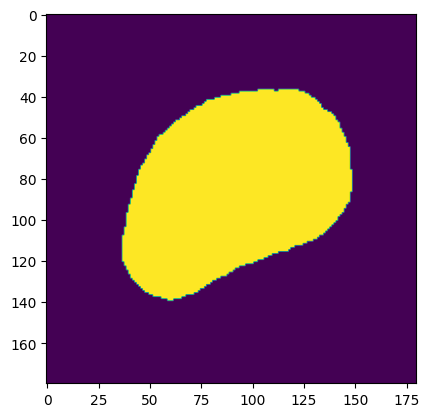

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy import ndimage as ndi
from skimage import data, filters, measure, segmentation

# segment nucleus
nucleus = data.protein_transport()[0, 0, :, :180]
smooth = filters.gaussian(nucleus, sigma=1.5)
thresh = smooth > filters.threshold_otsu(smooth)
fill = ndi.binary_fill_holes(thresh)
nucleus_seg = segmentation.clear_border(fill)
plt.imshow(nucleus_seg)

In [3]:
# protein blobs of varying intensity
proteinA = np.zeros_like(nucleus, dtype="float64")
proteinA_seg = np.zeros_like(nucleus, dtype="float64")

rng = np.random.default_rng()

for i in range(10):
  blobs = data.binary_blobs(180,
                            blob_size_fraction=0.5,
                            volume_fraction=(50/(180**2)),
                            ) #rng seed is optional
  blobs_image = filters.gaussian(blobs, sigma=1.5) * rng.integers(50, 256)
  proteinA += blobs_image
  proteinA_seg += blobs

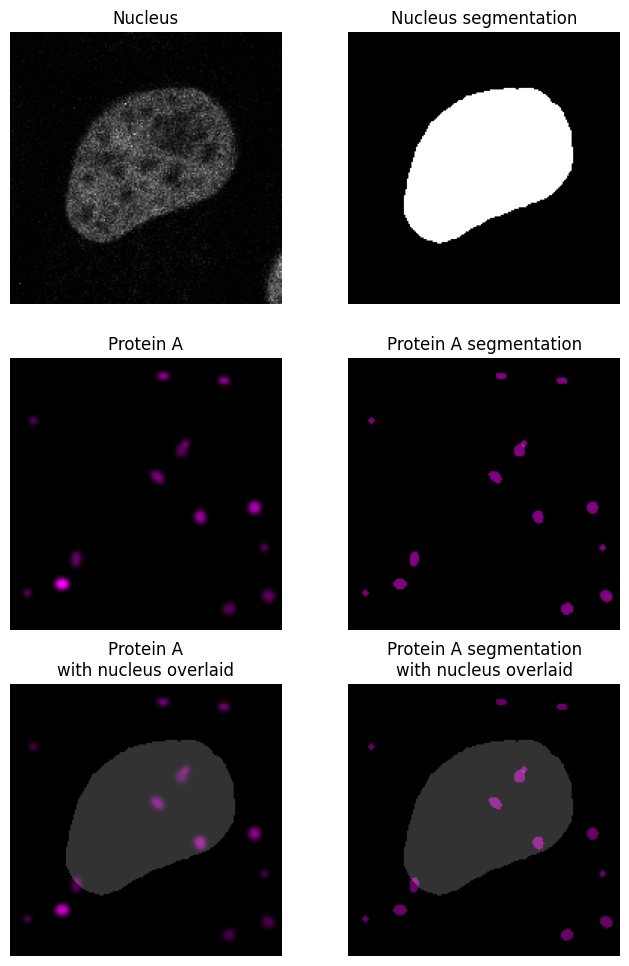

In [4]:
# plot data
fig, ax = plt.subplots(3, 2, figsize=(8, 12), sharey=True)
ax[0, 0].imshow(nucleus, cmap=plt.cm.gray)
ax[0, 0].set_title('Nucleus')

ax[0, 1].imshow(nucleus_seg, cmap=plt.cm.gray)
ax[0, 1].set_title('Nucleus segmentation')

black_magenta = LinearSegmentedColormap.from_list("", ["black", "magenta"])
ax[1, 0].imshow(proteinA, cmap=black_magenta)
ax[1, 0].set_title('Protein A')

ax[1, 1].imshow(proteinA_seg, cmap=black_magenta)
ax[1, 1].set_title('Protein A segmentation')

ax[2, 0].imshow(proteinA, cmap=black_magenta)
ax[2, 0].imshow(nucleus_seg, cmap=plt.cm.gray, alpha=0.2)
ax[2, 0].set_title('Protein A\nwith nucleus overlaid')

ax[2, 1].imshow(proteinA_seg, cmap=black_magenta)
ax[2, 1].imshow(nucleus_seg, cmap=plt.cm.gray, alpha=0.2)
ax[2, 1].set_title('Protein A segmentation\nwith nucleus overlaid')

for a in ax.ravel():
    a.set_axis_off()

In [5]:
#measure.intersection_coeff(proteinA_seg, nucleus_seg)

a1 = np.sum(proteinA_seg)
a2 = np.sum(proteinA_seg*nucleus_seg)

print(a2/a1)


0.35785288270377735


#Manders’ Colocalization Coefficient (MCC)
The overlap coefficient assumes that the area of protein segmentation corresponds to the concentration of that protein - with larger areas indicating more protein. As the resolution of images are usually too small to make out individual proteins, they can clump together within one pixel, making the intensity of that pixel brighter. So, to better capture the protein concentration, we may choose to determine what proportion of the intensity of the protein channel is inside the nucleus. This metric is known as Manders’ Colocalization Coefficient.

In this image, while there are a lot of protein A spots within the nucleus they are dim compared to some of the spots outside the nucleus, so the MCC is much lower than the overlap coefficient.

In [8]:
#measure.manders_coloc_coeff(proteinA, nucleus_seg)

a3 = np.sum(proteinA)
a4 = np.sum(proteinA*nucleus_seg)

print(a4/a3)

0.314038520282933


After choosing a co-occurence metric, we can apply the same process to control images. If no control images are available, the **Costes method** could be used to compare the MCC value of the original image with that of the randomly scrambled image. Information about this method is given in [1].

# Correlation: association of two proteins

Text(0, 0.5, 'Protein B intensity')

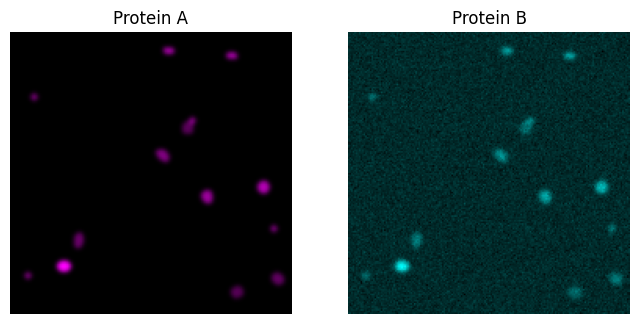

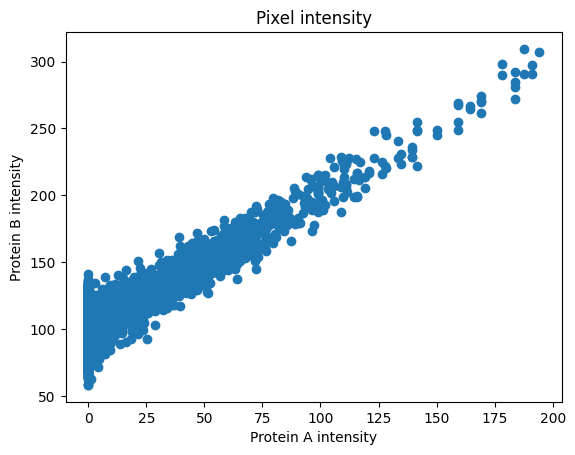

In [9]:
# generating protein B data that is correlated to protein A for demo
proteinB = proteinA + rng.normal(loc=100, scale=10, size=proteinA.shape)
# can also use array instead of generator as follows
# noise_array = np.random.randn(100,10,proteinA.shape)
# proteinB = proteinA + noise_array

# plot images
fig, ax = plt.subplots(1, 2, figsize=(8, 8), sharey=True)

ax[0].imshow(proteinA, cmap=black_magenta)
ax[0].set_title('Protein A')

black_cyan = LinearSegmentedColormap.from_list("", ["black", "cyan"])
ax[1].imshow(proteinB, cmap=black_cyan)
ax[1].set_title('Protein B')

for a in ax.ravel():
    a.set_axis_off()

# plot pixel intensity scatter
plt.figure()
plt.scatter(proteinA, proteinB)
plt.title('Pixel intensity')
plt.xlabel('Protein A intensity')
plt.ylabel('Protein B intensity')

In [25]:
# pcc, pval = measure.pearson_corr_coeff(proteinA, proteinB)
# print(f"PCC: {pcc:0.3g}, p-val: {pval:0.3g}")

pA = proteinA.ravel()
pB = proteinB.ravel()
pcc = np.sqrt(np.dot(pA,pB))/np.sqrt(np.sqrt(np.dot(pA,pA))*np.sqrt(np.dot(pB,pB)))
print(pcc)

from scipy.stats import pearsonr

res = pearsonr(pA,pB)
print(res)

0.5102251611854866
PearsonRResult(statistic=0.7351789790527661, pvalue=0.0)
